<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

In [30]:
#Libraries
import os
import cv2
from google.colab.patches import cv2_imshow
#----------------visualisation-------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [22]:
data_path = 'drive/MyDrive/faces/data'

In [21]:
faces = ['smiling-person', 'anger-person', 'disgust-person', 'fear-person', 'surprise-person' ]

In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
photos_number = []
for face in faces:
  photos_number.append(len(os.listdir(f'{data_path}/{face}')))

In [29]:
photos_number

[1200, 1169, 1190, 1173, 1198]

### 1.1 Data visualisation

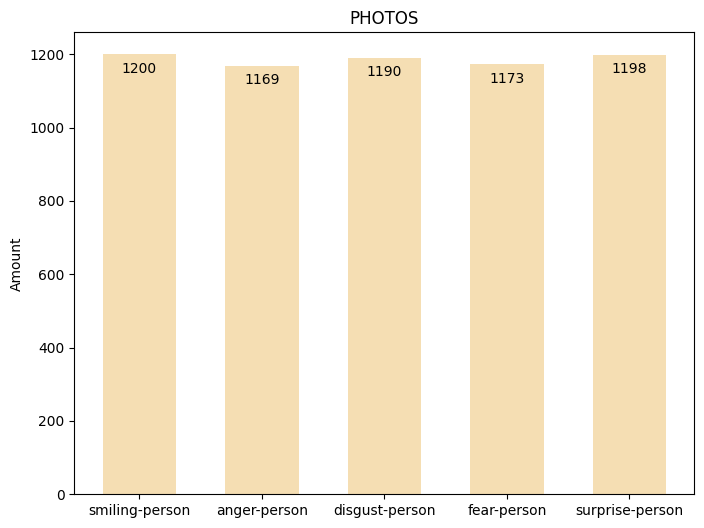

In [37]:
fig, ax = plt.subplots(figsize = (8,6))
ax.bar(faces, photos_number, color='wheat', width=0.6)
ax.set_title('PHOTOS')
ax.set_ylabel('Amount')

for i in range(0, len(faces)):
  ax.text(faces[i], photos_number[i] - 50, horizontalalignment='center', s=photos_number[i] )

*Dataset is quite balanced.*

In [10]:
imagePath = '/content/jodie-comer.png'

In [11]:
img = cv2.imread(imagePath)

In [12]:
img.shape

(780, 1150, 3)

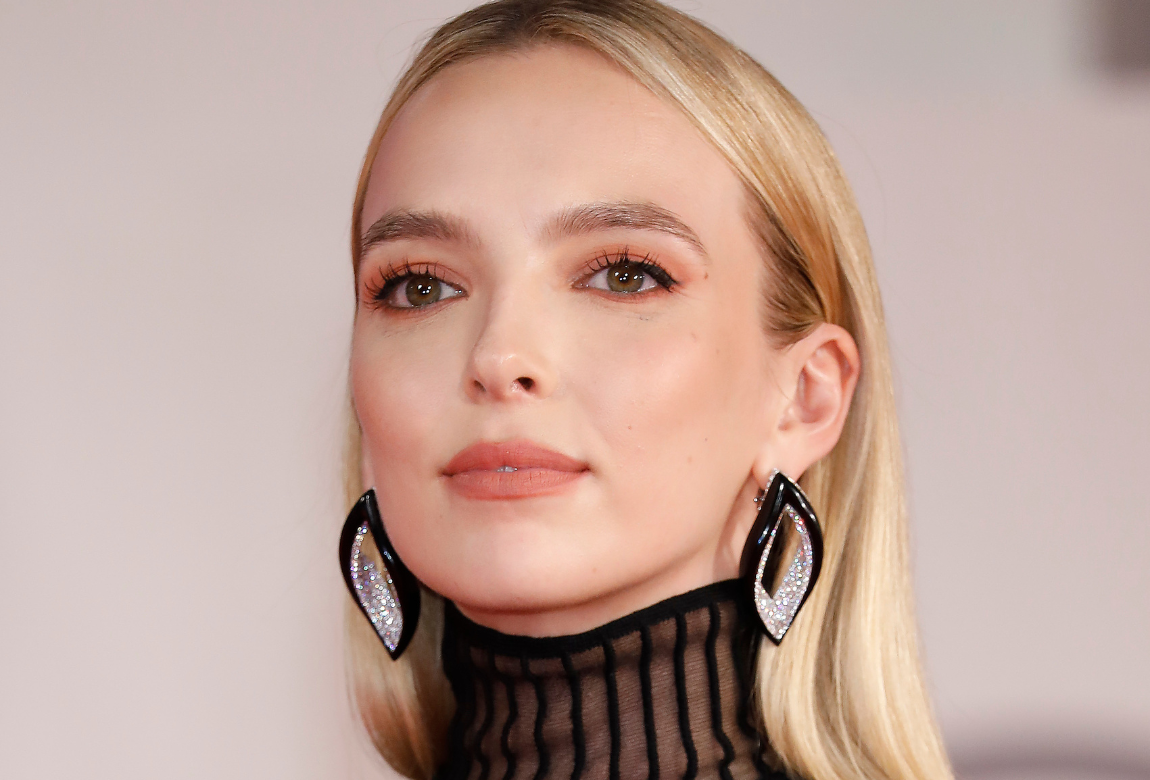

In [13]:
cv2_imshow(img)

In [14]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

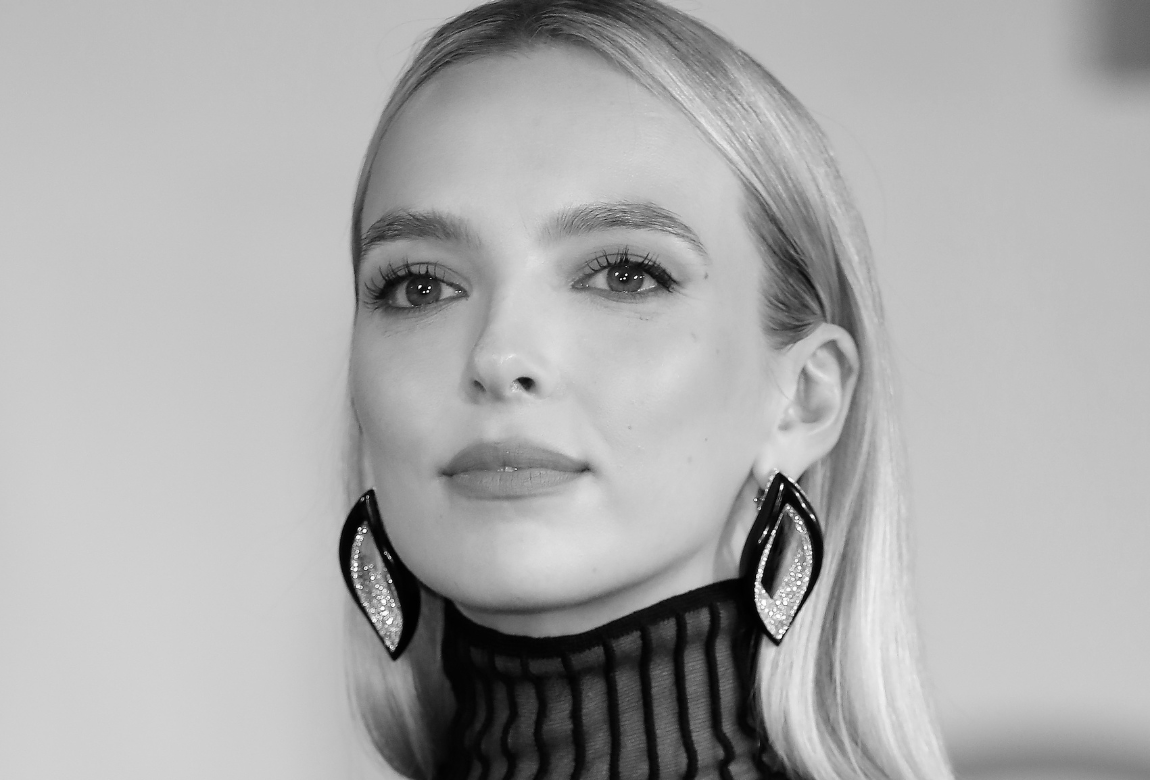

In [15]:
cv2_imshow(gray_image)

In [16]:
gray_image.shape

(780, 1150)

In [17]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [18]:
faces = face_classifier.detectMultiScale(gray_image, 1.3, 4)

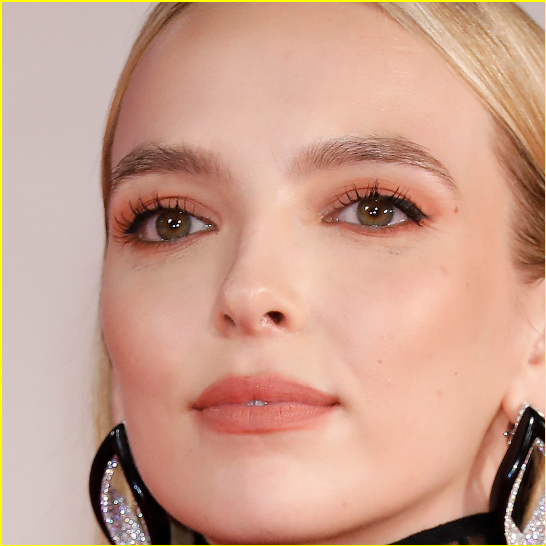

In [19]:
if len(faces) > 0:
   for i, (x, y, w, h) in enumerate(faces):
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
      face = img[y:y + h, x:x + w]
      cv2_imshow(face)

In [20]:
print('Number of detected faces:', len(faces))

Number of detected faces: 1
